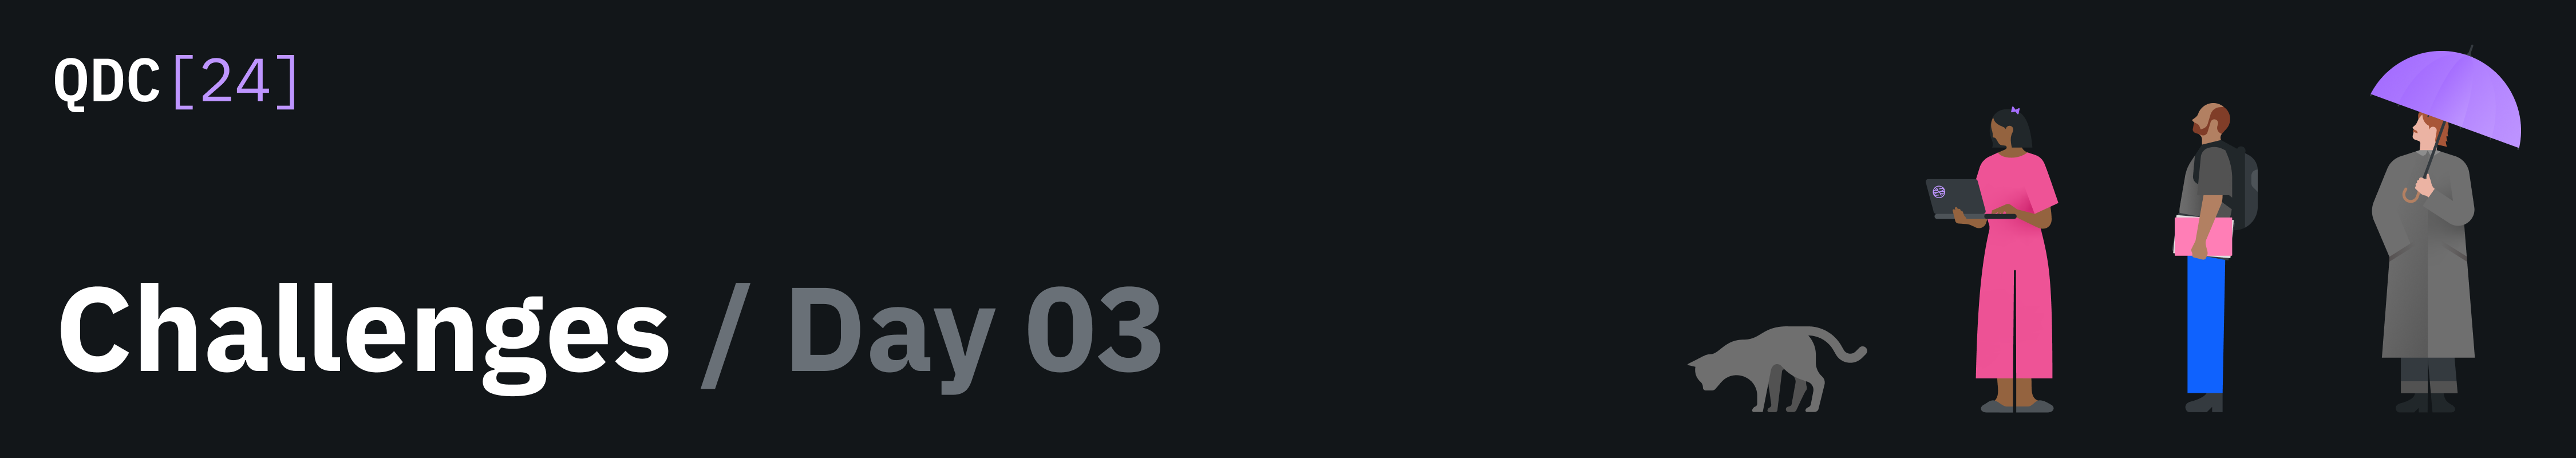

# Day 3 - Challenge Track A: Accuracy and Execution
This challenge is designed to teach you Qiskit's new debugging tool as well as the new noise learner techniques. The debugging tool `Neat` helps you to estimate if your circuit is ready to run on real hardware before actually using QPU time. With the `NoiseLearner` you can learn the noise model of your quantum circuit directly (not only implicitly) and use it in multiple experiments - for example, for zero-noise extrapolation. Additionally, you can now inspect and analyze the `NoiseLearnerResult` to get additional insights.


[You can find the notebook for Track B here](https://github.com/qiskit-community/qdc-challenges-2024/tree/main/Day_3/QDC_Day_3_Track_B.ipynb):

## Table of Contents

**Track A:**
1. [Section 1: Estimating potential for error mitigation](#section-1)
   - [Exercise 1: Estimating number of repetitions](#exercise-1)
2. [Section 2: Noise in layers](#section-2)
   - [Exercise 2: Setting layers](#exercise-2)
3. [Section 3: Layers for noise learning](#section-3)
   - [Exercise 3: Reducing the number of layers](#exercise-3)
4. [Section 4: The NoiseLearner and its options](#section-4)
   - [Exercise 4: Understanding noise learner results](#exercise-4)
5. [Section 5: Layers in practice](#section-5)
   - [Exercise 5: Obtaining the best noise model](#exercise-5)
6. [Section 6: A Neat circuit](#section-6)
   - [Exercise 6: Estimating optimized circuit](#exercise-6)

## Documentation Quick Reference 


|  Tool with link  |  Description  |
|---|---|
| [Neat debugging tool](https://docs.quantum.ibm.com/guides/debug-qiskit-runtime-jobs) |Tool for estimating quality of hardware results |
|[IBM Quantum Account](https://docs.quantum.ibm.com/guides/setup-channel)|How to set up your account|
|[Error mitigation options](https://docs.quantum.ibm.com/guides/runtime-options-overview)|Examples and explanation of error mitigation options in Qiskit Runtime|
|[Noise Learner](https://docs.quantum.ibm.com/guides/noise-learning)|Learning noise for a specific circuit using observables|
|[Convert ISA to Clifford](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.transpiler.passes.ConvertISAToClifford)|Transpiler pass that converts a quantum circuit to only contain Clifford gates|
|[Zero-Noise Extrapolation (ZNE) Options](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.ZneOptions)|Available options for ZNE in order to fine-tune error mitigation|
|[Probabilistic Error Amplification](https://docs.quantum.ibm.com/guides/error-mitigation-and-suppression-techniques#probabilistic-error-amplification-pea)|ZNE method that uses noise learning to get better results|
|[Twirling Options](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.TwirlingOptions)|Options used for twirling|

### Installing the required components


You will most likely have this already installed, but in case you start from a fresh Python environment, here is what you need.
Only run the cell below if you need to install the tools.

Ensure that the qiskit-ibm-runtime version you have is the newest - otherwise it might not include everything you need.

In [ ]:
# # In case this is not yet installed

# %pip install qiskit[visualization]>=1.0
# %pip install qiskit-ibm-runtime>=0.31
# %pip install qiskit-aer
# %pip install git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git

### Importing libraries


We import here all the libraries we will need in the notebook.

In [6]:
import numpy as np
import random
random.seed(10)

from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime.debug_tools import Neat
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.noise_learner import NoiseLearner
from qiskit_ibm_runtime.options import NoiseLearnerOptions
from qiskit.quantum_info import Statevector
import json
from qiskit.quantum_info import Operator
from utils_Track_A import circuit_ex1, circuit_ex3

from qiskit_ibm_runtime.utils import RuntimeEncoder, RuntimeDecoder


In [2]:
# Imports for the grader 
from qc_grader.challenges.qdc_2024_2 import (
    grade_day3a_ex1,
    grade_day3a_ex2,
    grade_day3a_ex3,
    grade_day3a_ex4,
    grade_day3a_ex5,
    submit_day3a_ex5,
    submit_name,
    submit_feedback_3a_1,
    submit_feedback_3a_2,
    submit_feedback_3a_3
)

In case you are starting with a fresh environment, here is how to save your IBM Quantum account - just change "Your_Token" to your private API token.

In [24]:
### Save API Token, if needed
 
# # Save an IBM Quantum account and set it as your default account.
# QiskitRuntimeService.save_account(
#     channel="ibm_quantum",
#     token="Your_Token",
#     set_as_default=True,
#     # Use `overwrite=True` if you're updating your token.
#     overwrite=True,
# )

For this challenge we use ibm_nazca  as our backend, and you also need to make sure to use the correct instance. Choose the correct instance from the ones below and add your personal instance for "user-n". (You can find the correct one on https://quantum.ibm.com/account under "Instances")




In [ ]:
# check which instance you are in
service = QiskitRuntimeService(channel='ibm_quantum', instance="events/qdc-participants/user-n")
#service = QiskitRuntimeService(channel='ibm_quantum', instance="events/qdc-participant2/user-n")


backend = service.backend("ibm_nazca")
#backend = service.least_busy(min_num_qubits=127)
#backend = service.backend("test_eagle_us-east")
print(backend.name)

## Section 1:  Estimating potential for error mitigation


Before implementing a resource-intensive circuit on a QPU, it is helpful to know whether it has potential to give the expected experimental results, and if error mitigation techniques could improve accuracy.
`Neat` analyzes and predicts the performance of your Estimator queries. Since `Neat` uses a Cliffordization of your quantum circuit, it efficiently simulates the quantum circuit classically, whether in ideal conditions or in the presence of noise. You can compare noisy results with the ideal ones to determine whether your expectation values are good enough to be improved by error mitigation techniques or if they are too noisy. 

Documentation links: 
- [The Neat class](https://docs.quantum.ibm.com/guides/debug-qiskit-runtime-jobs)
- [ConvertISAToClifford](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.transpiler.passes.ConvertISAToClifford) function that converts quantum circuits into Clifford circuits 
- The [debugging tools module](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/debug_tools)

### Exercise 1

In some quantum algorithms we want to repeat our ansatz for best results, but it is hard to say how many times to repeat. We now want to use Neat to test how often we can repeat an ansatz in a quantum circuit such that we are still able to get a good result when using error mitigation according to the guidelines below.

We will use the helper function `"circuit_ex1"` to generate a circuit. The function has a parameter `"repetitions"`, which represents how often the ansatz is repeated.  


<a id="exercise_1"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 1: Estimate the number of repetitions</b> 

Use Neat and the simplified guidelines below to test how many repetitions of the following ansatz ("circuit_ex1") you can maximally have in a circuit if you wanted to use zero-noise extrapolation (ZNE). The answer is the maximum number of repetitions that still allows you to use ZNE with PEA.
</div> 

Use the debugging tool and calculate the noisy expectation value to estimate how well the circuit would work with ZNE.

We will use the following simplified guidelines for this exercise:

- We assume that the expectation value for a non-noisy simulation is 1 and then:
- if the noisy expectation value < 0.1: nothing is going to help
- if the noisy expectation value 0.1~0.2, zero-noise extrapolation with probabilistic error amplification might be able to help
- if the noisy expectation value 0.2, use zero-noise extrapolation with gate folding

These are just estimates. In practice, PEA and PEC can also be used with smaller expectation values, if the noise can be captured well enough. 



We can now prepare the parameters and observables and inspect the ansatz itself (only 1 repetition).

In [ ]:
noise_model = None  # option to specify a custom `NoiseModel`

# Initialize a neat object
analyzer = Neat(backend, noise_model)

paramsx = np.zeros((14,2))

# Define an observable
observables = []
observables.append(SparsePauliOp("Z" * (14)))

# Draw 1 repetition of the circuit
qc = circuit_ex1(paramsx=paramsx,repetitions=1)
qc.draw(output='mpl', fold=False)

<div class="alert alert-block alert-warning">
    
⚠️ **Please note** 

Since we want to test how this works on a backend, we need to transpile the circuit for a backend; for this, we will use the `pass_manager`. We use a fixed seed here to make sure it is reproducible - please do NOT change it!
</div>




In [108]:
# Using the pass manager to optimize it for the backend - DO NOT change the seed
pm = generate_preset_pass_manager(backend=backend, optimization_level=0, seed_transpiler=1)

### Your solution to Exercise 1:

Test the circuit with a different number of repetitions for the ansatz and then submit the maximum number of repetitions that still allows the use of ZNE. 

In [ ]:
repetitions = # Change the value for getting different numbers of repetition

# Generating the circuit for testing
qc = circuit_ex1(paramsx,repetitions)

optimized_circuit = pm.run(qc)

# Transpiling the circuit for the correct backend and adapt the observables
layout = optimized_circuit.layout
optimized_observables = [obs.apply_layout(layout=layout) for obs in observables]

pubs=[(optimized_circuit,optimized_observables)]
# optimized_circuit.draw(output='mpl', idle_wires=0)

# We need to turn the circuit into a clifford circuit before using Neat
clifford_pubs = analyzer.to_clifford(pubs)
# clifford_pubs[0].circuit.draw(output='mpl', idle_wires=0)

# We first want to calculate the ideal value, which should be 1
ideal_vals = analyzer.ideal_sim(clifford_pubs, seed_simulator=10)
print(f'Ideal expectation value for {repetitions} repetitions: {ideal_vals}')

# Now we calculate the noisy value to compare it
noisy_vals  = analyzer.noisy_sim(clifford_pubs, seed_simulator=10)
print(f'Noisy expectation value for {repetitions} repetitions: {noisy_vals}')


#### Submit your result

In [ ]:
# Submit your answer using the following code:

grade_day3a_ex1(repetitions) # Maximum number of repetitions

<div class="alert alert-block alert-info">
        <strong> Feedback Question 1:</strong><br>
   How helpful do you find the debugging tool? Are there any expectations you have for a debugging tool that this tool does not address? Please explain.
</div>

In [1]:
# We would appreciate any feedback

feedback =
submit_feedback_3a_1(feedback)

## Section 2: Noise in layers


There are different ways to look at noise. A simple way is to just look at each individual operation, and determine how noisy the operation is.
Another way is to look at all operations happening at the same time, and consider them as one unit as a so-called layer, then learn the noise of these layers. When the noise is known, error mitigation can be better used to mitigate the learned noise.
We define a layer as a slice of a circuit that contains a group of non-overlapping gates acting on a subset of qubits. 
Since the two-qubit operations have an order-of-magnitude higher error rate, we focus only on the two-qubit gates; and when we speak about layers, we only consider layers of two-qubit gates, ignoring the single-qubit gates. A single layer is a unique combination of two-qubit gates that execute concurrently. We assume that a given layer will have a consistent noise; therefore, we only need to learn the noise of each unique layer once. 


With that in mind, you will implement the circuit for the `NoiseLearner`, which is designed to learn the noise model of a given number of unique layers. Since each layer needs time to be learned, identifying and decreasing the number of unique layers can accelerate the noise learning process. Therefore, reusing layers provides several benefits:
- Reduces QPU usage spent on the learning procedure
- Allows you to directly analyze the learned model (and potentially modify it)
- Verifies that the noise on the device is what you expect before executing Estimator workloads


<div class="alert alert-block alert-warning">
    
⚠️ **Please note** 

We only consider the two-qubit layers here. When counting the number of layers, you can ignore one-qubit layers.
</div>


### Exercise 2


In this exercise we will try to analyze the number of two-qubit layers of a circuit by hand in order to get a better understanding of layers. As mentioned above, it is normally a good idea to reduce the number of layers; therefore, we are looking for the least number of layers of the given circuit. 

We will split the circuit into different layers using barriers, which help make it easier to see where the layers are.



<a id="exercise_2"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 2: Determine the number of unique layers </b> 

Using barriers to slide the circuit into different layers, determine how many different unique two-qubit gate layers this circuit has.
</div> 


This is the given quantum circuit before any barriers are applied:

In [ ]:
num_qubits = 5 # Number of qubits

np.random.seed(10)
params = np.random.uniform(0,np.pi/2,size=(num_qubits,2))

qc = QuantumCircuit(num_qubits)
for i in range(num_qubits):
    qc.ry(params[i,0],i)
qc.cx(0,1)
qc.cx(3,4)
qc.cx(1,2)
for i in range(num_qubits):
    qc.ry(params[i,1],i)
qc.cx(3,4)
qc.cx(1,2)
qc.draw('mpl' )

Feel free to add barriers to the circuit to separate the layers:

In [ ]:
qc = QuantumCircuit(num_qubits)
for i in range(num_qubits):
    qc.ry(params[i,0],i)

# Add barriers between operations as you see fit
qc.barrier()

qc.cx(0,1)
qc.cx(3,4)
qc.cx(1,2)
for i in range(num_qubits):
    qc.ry(params[i,1],i)
qc.cx(3,4)
qc.cx(1,2)
qc.draw(output='mpl')

### Your solution to Exercise 2:


In [ ]:
num_unique_layers = # Write your answer here

#### Submit your result

In [ ]:
# Submit your answer using the following code:

grade_day3a_ex2(num_unique_layers) # Minimum number of two-qubit layers

## Section 3: Layers for noise learning

As mentioned above, layers can be used to learn the noise of circuits. Since learning noise layers can take a significant amount of time, in this exercise we want to reduce the number of unique layers, and with that, reduce the amount of time required to do noise learning. 

In some cases, you can dramatically reduce the number of unique layers with quick circuit manipulations using symmetries and equalities. By constructing a circuit in a way that places entangling gates in a consistent way, you can guide the Estimator to find a minimal set of layers to learn. The quantum circuits shown in the two cells below demonstrate a circuit manipulation. They represent the same unitary operator, since the CZ gate is symmetrical.

In [ ]:
qc = QuantumCircuit(3)
qc.cz(0,1)
qc.cz(1,2)
qc.draw(output='mpl')

In [ ]:
qc0 = QuantumCircuit(3)
qc0.cz(1,2)
qc0.cz(0,1)
qc0.draw(output='mpl')

Let's check the equivalence:

In [ ]:
Operator(qc) == Operator(qc0)

The CZ gate can be used to simplify certain circuits, but it is not the only one that allows for simplifications. In fact, we can express CZ with a single instance of other two-qubit gates. As an example, a CZ gate can be constructed with a single ECR gate + local rotations of the qubit. We use in this example the CZ gate specifically, since it makes this exercise simpler.

### Exercise 3

In the next example, we use the equivalence shown above to reduce the number of layers in a circuit, without affecting the quantum state of the circuit. 

<a id="exercise_3"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 3: Reduce the number of layers</b> 

In the following circuit, use the symmetry of the CZ gate shown above to reduce the total depth of the circuit (and especially the number of unique layers) by moving the gates around. 

*Hint: It can be easier to see the different layers if you add barriers between them.*
</div> 



This is our initial quantum circuit, which has several CZ gates and several layers. 

In [ ]:
num_qubits = 8 # Number of qubits
reps = 2 # Number of repetitions

np.random.seed(10)
params = np.random.uniform(0,np.pi/2,size=(num_qubits,reps))

qc = circuit_ex3(params)
print('Number of 2-qubit gates layers:', qc.depth(lambda x: len(x.qubits) == 2))
qc.draw(output='mpl')

### Your solution to Exercise 3:

Construct an equivalent circuit with the least number of unique layers as possible:

In [ ]:
qc = QuantumCircuit(num_qubits)
qc.h(range(num_qubits))
# Write your code here



print('Number of 2-qubit gates layers:', qc.depth(lambda x: len(x.qubits) == 2))
qc.draw(output='mpl')

#### Submit your result

In [ ]:
# Submit your answer using the following code:

grade_day3a_ex3(qc) # circuit with the reduced number of two-qubit layers

## Section 4: The NoiseLearner and its options

Learning the noise model of a quantum circuit is important both because it helps in measuring progress towards more performant QPUs, and because when noise models are known, they can be mitigated.

Qiskit’s [NoiseLearner](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.noise_learner.NoiseLearner) program implements an efficient and scalable protocol to provide useful information about the noise model of the layers. With the learned noise model, you can use two different error mitigation techniques:
- [Probabilistic error amplification (PEA)](https://docs.quantum.ibm.com/guides/error-mitigation-and-suppression-techniques#probabilistic-error-amplification-pea) builds around noise amplification, amplifying the circuit’s noise by factors $\alpha_1$, $\alpha_2$, ..., and then extrapolates the value at $\alpha = 0$. It produces a (possibly biased) estimator with little sampling overhead, and it is more precise than digital [ZNE](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/dev/qiskit_ibm_runtime.options.ZneOptions), thanks to accurate noise learning.

- [Probabilistic error cancellation (PEC)](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.PecOptions) builds around noise inversion, i.e., it appends the inverse map to each of the layers in the target circuit, producing an unbiased estimator [[ref](https://www.nature.com/articles/s41567-023-02042-2)]. The sampling overhead grows exponentially.

NoiseLearner [options](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.NoiseLearnerOptions): 
- `layer_pair_depths`: the circuit depths (measured in number of pairs) to use in learning experiments.
- `max_layers_to_learn`: the maximum number of unique layers to learn.
- `num_randomizations`: the number of random circuits to use per learning circuit configuration. A configuration is a measurement basis and depth setting.
- `shots_per_randomization`: the total number of shots to use per random learning circuit. A learning circuit is a random circuit at a specific learning depth with a specific measurement basis executed on hardware.
- `twirling_strategy`: the twirling strategy in the identified layers of two-qubit twirled gates.

[Pauli twirling strategies](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/dev/qiskit_ibm_runtime.options.TwirlingOptions):

- `"active"`: only the instruction qubits in each individual twirled layer will be twirled.
- `"active-circuit"`: the union of all instruction qubits in the circuit will be twirled in each twirled layer.
- `"active-accum"`: the union of instruction qubits in the circuit up to the current twirled layer will be twirled in each individual twirled layer.
- `"all"`: all qubits in the input circuit will be twirled in each twirled layer.

Default: `“active-accum”`.

For example, if you want to save time, you can twirl only the used qubit in each twirled layer with `"active"`. However, if you want to avoid crosstalk errors in idling qubits, the `"all"` strategy would be a good choice.



### Exercise 4

In this exercise you will learn more about the options of the NoiseLearner, by determining which options were used to generate a particular NoiseLearnerResult. You will also determine what the original circuit looked like. Use this exercise to thoroughly understand what exactly happens with specific settings given a particular circuit. 






<a id="exercise_4"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 4: Determine the options used</b> 

Exercise: Given the following noise model, conclude which of the quantum circuits below has been used to calculate it. In addition, find which parameters were used by inspecting the results. 

*Hint: If you cannot know the option from the data, then you do NOT have to set it.*
</div> 


One of the following circuits was used:



QC1:

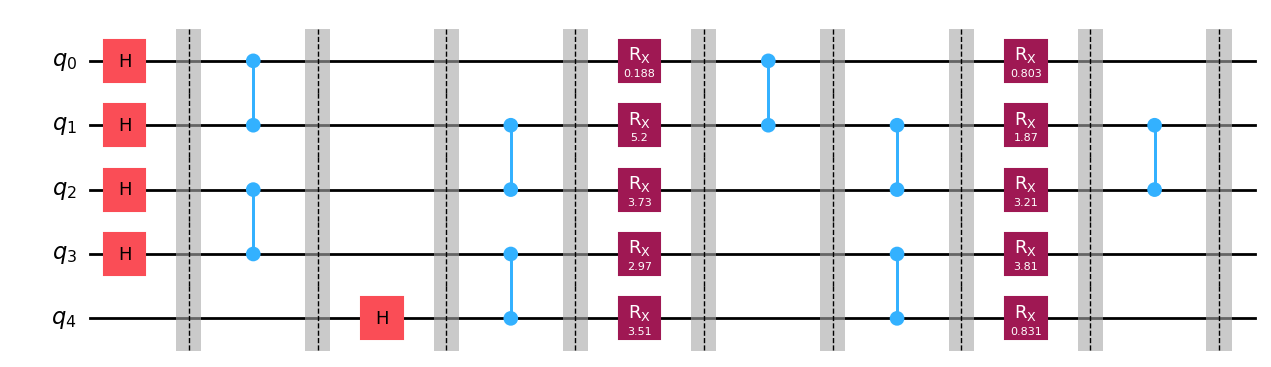


QC2:

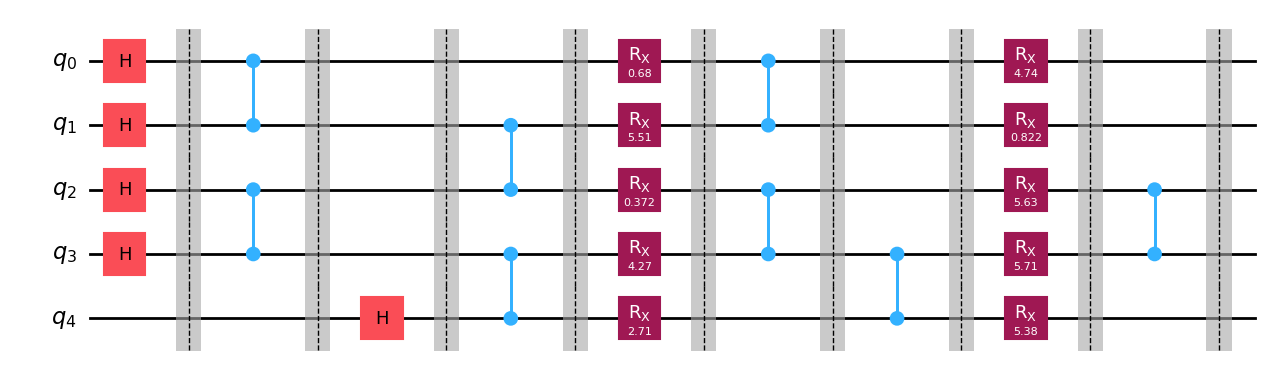


Now load the noise model and play around with it in order to find which of the circuits above was used, as well as the parameters which were used, such as `max_layers_to_learn`, `twirling_strategy`, and so forth.

In [74]:
with open("NoiseModels/exercise4_noisemodel.json", "r") as file:
    encoded_from_file = file.read()
decoded = json.loads(encoded_from_file, cls=RuntimeDecoder)
noise_model = decoded['data']

# You can draw the layers with the following code:
# noise_model[0].circuit.draw(output='mpl', idle_wires=0)

# The number of layers is given by the number of entries

### Your solution to Exercise 4:

In [ ]:
# Write your code here
learner_options = NoiseLearnerOptions(
    max_layers_to_learn=, 
    twirling_strategy= 
    # Add more options if necessarily
)

chosen_circuit = # which circuit was it circuit 1 or 2?

#### Submit your result

In [ ]:
# Submit your answer using the following code:

grade_day3a_ex4(learner_options, chosen_circuit) 

<div class="alert alert-block alert-info">
    <strong> Feedback Question 2:</strong><br>
    Had you heard about the NoiseLearner tool before this challenge?
</div>


In [74]:
# We would appreciate any feedback

feedback =
submit_feedback_3a_2(feedback)

<div class="alert alert-block alert-info">
    <strong> Feedback Question 3:</strong><br>
    Do envision using the NoiseLearner in the future? If so, please expand on how you plan to incorporate it into your workflow. If not, please share why you do not believe you will use it.
</div>


In [74]:
# We would appreciate any feedback

feedback =
submit_feedback_3a_3(feedback)

## Section 5: Layers in practice




### Exercise 5:

We now come to the graded exercise. Here we will incorporate everything we learned so far in order to reduce the number of unique layers of a more complex circuit. This is similar to exercise 3, but is more challenging. The grading considers only the number of unique layers; however, you can also test the depth of the circuit yourself, since reducing the depth, as a first step, will also improve the result. We will use the same circuit as in exercise 1, except we will only use a single repetition (since we only care about the number of unique layers, and they will be the same, even if we have several repetitions). 


<div class="alert alert-block alert-warning">
    
⚠️ **Please note** 

Always test the depth of your circuit first and visualize it before sending it to the grader. Only send in circuits that have a low-enough depth and a low number of unique layers. 
</div>


<a id="exercise_5"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 5: Reduce the number of unique layers</b> 

Reduce the depth and especially the number of unique layers of the circuit given from exercise 1. Use different tricks and transpilation to reduce the number of unique layers  as much as possible. This is a scored exercise. 
</div> 


Circuit before your manipulation:

In [ ]:
num_qubits = 14
np.random.seed(10)
paramsx = np.random.uniform(0,np.pi/2,(num_qubits,2))
## We use a single repetition as mentioned above
qc0 = circuit_ex1(paramsx,1)

pm = generate_preset_pass_manager(backend=backend, optimization_level=1, initial_layout=range(14))
optimized_circuit0 = pm.run(qc0)
print('Number of 2-qubit gates layers:', optimized_circuit0.depth(lambda x: len(x.qubits) == 2))
print(f'Number of 2-qubit gates: {optimized_circuit0.size(lambda x: x.operation.num_qubits == 2)}')
# optimized_circuit.draw(output='mpl', idle_wires=0)
qc0.draw(output='mpl', fold=False)

<div class="alert alert-block alert-warning">
    
⚠️ **Scored exercise** 

Now it's time for the scored exercise. Your best score from this exercise will be used to calculate your position on the QDC leaderboard!

</div>

### Your solution to Exercise 5:

Create a function that constructs the circuit, as above, for the given parameters. Submit both the abstract form and the transpiled form for the backend.

In [ ]:
def ex_5_solution(paramsx):

    # This should be your optimized circuit
    optimized_circuit = QuantumCircuit(num_qubits)

    # Write your code here
    pm = # Write your code here

    # Here the transpiled circuit make sure you include the correct layout etc.
    transpiled_circuit = pm.run(qc)

    return optimized_circuit, transpiled_circuit

#### Submit your result

In [ ]:
# Submit your function from above using the following code:

job_for_grading = submit_day3a_ex5(ex_5_solution) # function to construct the given circuit with a low number of layers

# To print the error in case the submission was not successful
if type(job_for_grading) == str:
    print(job_for_grading)

In [ ]:
# Check job status
print(job_for_grading.status())

In [ ]:
# Please choose your username for the leaderboard

username = 
submit_name(username)

In [ ]:
# Once your job is "DONE" you can submit it here to get your grading:

grade_day3a_ex5(job_for_grading)

The result you received from the above code shows the number of unique layers, the lower the number the better.

## Section 6: A Neat circuit



In Exercise 5, we optimized our quantum circuit to reduce the number of unique layers.  We also reduced the number of two-qubit gates, which improves the performance of the noisy device. You can verify this improvement using the debugging tool! This helps us to understand what effect our optimization had not only on the noise learning, but on the general running of the circuit.

### Exercise 6

We now connect back to exercise 1 and to the debugging tool `Neat`. We want to use `Neat` to test how much we improved the circuit from exercise 5.


<a id="exercise_6"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 6: Verify that your circuit is well-suited for error mitigation</b> 

Use the Neat tool introduced in exercise 1 to test whether the circuit is well-suited for error mitigation. How much did it improve?
</div> 



In order to get a baseline, we will use the debugging tool for the quantum circuit from exercise 5 before your optimization steps.

In [ ]:
noise_model = None
analyzer = Neat(backend, noise_model)

qc0 = circuit_ex1(np.zeros((num_qubits,2)),1)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1, initial_layout=range(14), seed_transpiler=1 )
optimized_circuit0 = pm.run(qc0)
# print(optimized_circuit0)

observables = []
observables.append(SparsePauliOp("Z" * (num_qubits)))
layout = optimized_circuit0.layout
optimized_observables0 = [obs.apply_layout(layout=layout) for obs in observables]
pubs=[(optimized_circuit0,optimized_observables0)]

clifford_pubs = analyzer.to_clifford(pubs)
ideal_vals = analyzer.ideal_sim(clifford_pubs, seed_simulator=10)
print(f'Ideal expectation value: {ideal_vals}')
noisy_vals0  = analyzer.noisy_sim(clifford_pubs, seed_simulator=10)
print(f'Noisy expectation value: {noisy_vals0}')

### Your solution to Exercise 6 

Now use the debugging tool to analyze how much you improved the circuit from exercise 5:

In [ ]:
qc, optimized_circuit = ex_5_solution(np.zeros((num_qubits,2)))

layout = optimized_circuit.layout
optimized_observables = [obs.apply_layout(layout=layout) for obs in observables]
pubs=[(optimized_circuit,optimized_observables)]

# Write your code here





Thanks to your optimization, the noisy expectation value is now higher than before, and this means this circuit will run better on a real quantum device. Good job!

Since this exercise tests your personal progress for your solution of exercise 5, you do not need to submit the solution. This exercise is here for you to see how much you improved the circuit!

## Thank You for Participating!

Congratulations on completing **Day 3 of the Quantum Developer Challenge (QDC)**! 

Today you learned about noise layers and the NoiseLearner, and applied the theoretical knowledge learned from this morning in order to improve circuits for running on a QPU. 

In addition, you tested the debugging tool Neat in order to estimate circuits. 

Feel free to refer back to this notebook, check out the other track, revisit exercises, and try some of the optional sections to refine your skills. We hope this journey has inspired you to push the boundaries of quantum computing!

We hope you enjoyed these last three days and learned from both the talks as well as the challenges. 

See you next year!

# Additional information

**Created by:** Simone Cantori, Marcel Pfaffhauser

**Advised by:** Junye Huang, Sam Ferracin, Jessie Yu

**Version:** 1.0.0